In [21]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the pickel file
with open('../tracker_stubs/shuttle_detections.pkl','rb') as f:
    shuttle_positions = pickle.load(f)

In [66]:
shuttle_positions

[{1: [752.5951538085938,
   279.394287109375,
   760.7747192382812,
   293.645263671875]},
 {1: [752.5951538085938,
   279.394287109375,
   760.7747192382812,
   293.645263671875]},
 {1: [752.5951538085938,
   279.394287109375,
   760.7747192382812,
   293.645263671875]},
 {1: [749.3903381347657,
   277.6819274902344,
   757.6326232910156,
   292.0456237792969]},
 {1: [746.1855224609375,
   275.9695678710938,
   754.49052734375,
   290.44598388671875]},
 {1: [742.9807067871094,
   274.2572082519531,
   751.3484313964843,
   288.8463439941406]},
 {1: [739.7758911132812,
   272.5448486328125,
   748.2063354492187,
   287.2467041015625]},
 {1: [736.5710754394531,
   270.8324890136719,
   745.0642395019531,
   285.6470642089844]},
 {1: [733.366259765625,
   269.12012939453126,
   741.9221435546875,
   284.04742431640625]},
 {1: [730.1614440917969,
   267.40776977539065,
   738.7800476074219,
   282.4477844238281]},
 {1: [726.9566284179688, 265.69541015625, 735.6379516601562, 280.8481445312

In [5]:
shuttle_positions = [x.get(1, []) for x in shuttle_positions]
# convert list in to pd dataframe
df_shuttle_positions = pd.DataFrame(shuttle_positions, columns=['x1', 'y1', 'x2', 'y2'])
#interpolate the missing values
df_shuttle_positions = df_shuttle_positions.interpolate()
df_shuttle_positions = df_shuttle_positions.bfill()
shuttle_positions  = [{1:x} for x in df_shuttle_positions.to_numpy().tolist()]

In [12]:
df_shuttle_positions['mid_y'] = (df_shuttle_positions['y1'] + df_shuttle_positions['y2'] )/2
df_shuttle_positions['mid_y_rolling_mean'] = df_shuttle_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()


In [13]:
df_shuttle_positions

,x1,y1,x2,y2,mid_y,mid_y_rolling mean,mid_y_rolling_mean
0,752.595154,279.394287,760.774719,293.645264,286.519775,286.519775,286.519775
1,752.595154,279.394287,760.774719,293.645264,286.519775,286.519775,286.519775
2,752.595154,279.394287,760.774719,293.645264,286.519775,286.519775,286.519775
3,749.390338,277.681927,757.632623,292.045624,284.863776,286.105775,286.105775
4,746.185522,275.969568,754.490527,290.445984,283.207776,285.526176,285.526176
...,...,...,...,...,...,...,...
261,560.559570,138.208206,569.429688,153.842636,146.025421,162.925401,162.925401
262,555.468079,118.454044,564.286072,134.258781,126.356413,153.720458,153.720458
263,550.376587,98.699883,559.142456,114.674927,106.687405,141.279144,141.279144
264,544.408325,78.218285,553.546021,94.098961,86.158623,125.429505,125.429505


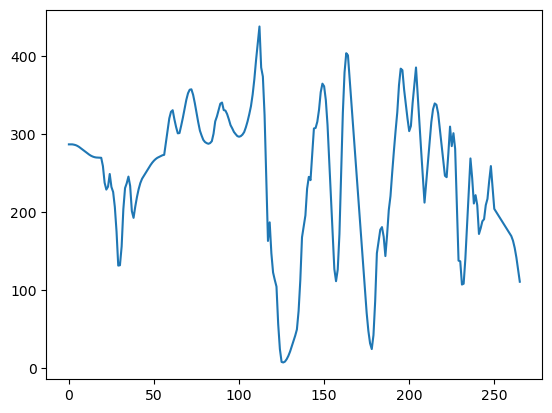

In [14]:
plt.plot(df_shuttle_positions['mid_y_rolling_mean'])

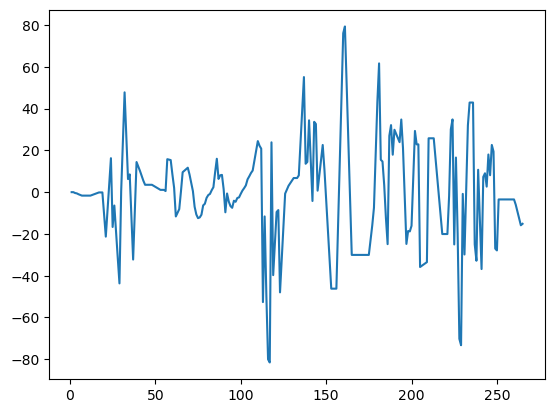

In [15]:
df_shuttle_positions['delta_y'] = df_shuttle_positions['mid_y_rolling_mean'].diff()
plt.plot(df_shuttle_positions['delta_y'])

In [51]:
df_shuttle_positions['mid_y'] = (df_shuttle_positions['y1'] + df_shuttle_positions['y2'] )/2
df_shuttle_positions['mid_y_rolling_mean'] = df_shuttle_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

df_shuttle_positions['ball_hit'] = 0

minimum_change_frames_for_hit = 7
for i in range(1, len(df_shuttle_positions)-int(minimum_change_frames_for_hit*1.2)):
    negative_position_change = df_shuttle_positions['delta_y'].iloc[i] > 0 and df_shuttle_positions['delta_y'].iloc[i+1] < 0 
    positive_position_change = df_shuttle_positions['delta_y'].iloc[i] < 0 and df_shuttle_positions['delta_y'].iloc[i+1] > 0 

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_shuttle_positions['delta_y'].iloc[i] > 0 and df_shuttle_positions['delta_y'].iloc[change_frame] < 0 
            positive_position_change_following_frame = df_shuttle_positions['delta_y'].iloc[i] < 0 and df_shuttle_positions['delta_y'].iloc[change_frame] > 0 
            
            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
        
        if change_count>minimum_change_frames_for_hit-1:
            df_shuttle_positions['ball_hit'].iloc[i] = 1
            
frame_nums_with_ball_hits = df_shuttle_positions[df_shuttle_positions['ball_hit']==1].index.tolist()

In [54]:
df_shuttle_positions[df_shuttle_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling mean,mid_y_rolling_mean,delta_y,ball_hit
38,548.047729,214.141296,557.196533,230.363800,222.252548,192.225304,192.225304,-8.688858,1
64,440.269386,302.719475,448.737846,316.999107,309.859291,300.685983,300.685983,-8.117686,1
72,387.817535,338.186584,396.797394,353.877380,346.031982,357.150638,357.150638,0.498560,1
82,387.936523,280.790955,396.193481,294.950562,287.870758,287.262622,287.262622,-0.833411,1
90,388.054871,332.139038,396.831970,347.633911,339.886475,340.147058,340.147058,1.411139,1
100,370.403931,290.657715,379.036743,306.029419,298.343567,296.309552,296.309552,-0.818347,1
112,625.416809,451.232361,633.797668,466.223694,458.728027,437.770416,437.770416,20.820392,1
118,577.621643,237.584167,586.527405,253.060791,245.322479,186.469114,186.469114,23.852063,1
126,448.593262,0.000000,457.505493,14.447632,7.223816,6.687023,6.687023,-0.700491,1
142,459.271505,294.596151,468.103007,309.772502,302.184326,240.597861,240.597861,-4.225610,1


In [ ]:
frame_nums_with_ball_hits = df_shuttle_positions[df_shuttle_positions['ball_hit']==1].index.tolist()

In [56]:
import pickle 
  
# Open the file in binary mode 
with open('../tracker_stubs/player_detections.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    myvar = pickle.load(file) 
  
    print(myvar[0]) 

{1: [600.2584228515625, 389.32989501953125, 681.094970703125, 587.0681762695312], 2: [614.965087890625, 269.662353515625, 705.225341796875, 408.9173583984375], 3: [113.041259765625, 322.47027587890625, 195.39755249023438, 460.46173095703125], 4: [694.2353515625, 360.8538818359375, 776.8240966796875, 520.5390625], 5: [396.5072326660156, 168.3446044921875, 440.8548889160156, 229.31356811523438], 6: [84.2598876953125, 172.77374267578125, 139.5603485107422, 287.4700622558594], 7: [853.1170654296875, 170.5790557861328, 897.0247802734375, 228.02003479003906], 8: [145.511962890625, 169.58670043945312, 201.839111328125, 275.50927734375], 9: [1101.2760009765625, 206.5322265625, 1183.9674072265625, 345.03912353515625]}


In [63]:
print(f"total frames: {len(myvar)}")

total frames: 266


In [65]:
for i in range(6, len(myvar)):
    print(myvar[i].keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
dict_keys([1, 2